In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

In [2]:
df = pd.read_csv(r"C:\Users\lenovo\Desktop\projetsmartbuilding\predictive-maintenance-dataset.csv", sep=';')  # Replace with your CSV path
print("Dataset preview:")
print(df.head(100))


Dataset preview:
   ball-bearing  humidity vibration
0        93.744    73.999        18
1         93.74    73.999    18.001
2        93.736    73.998    18.002
3        93.732    73.998    18.003
4        93.729    73.998    18.004
..          ...       ...       ...
95       93.377    73.968    18.095
96       93.374    73.968    18.096
97        93.37    73.967    18.097
98       93.366    73.967    18.098
99       93.362    73.967    18.099

[100 rows x 3 columns]


In [3]:
print(df.dtypes)
print(df.head(10))


ball-bearing     object
humidity        float64
vibration        object
dtype: object
  ball-bearing  humidity vibration
0       93.744    73.999        18
1        93.74    73.999    18.001
2       93.736    73.998    18.002
3       93.732    73.998    18.003
4       93.729    73.998    18.004
5       93.725    73.997    18.005
6       93.721    73.997    18.006
7       93.717    73.997    18.007
8       93.713    73.996    18.008
9       93.709    73.996    18.009


In [4]:
df = df.fillna(method='ffill')  # Forward fill
df = df.fillna(method='bfill')  # Backward fill


C:\Users\lenovo\AppData\Local\Temp\ipykernel_14276\1059885306.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14276\1059885306.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')  # Backward fill


In [5]:
# Convert columns to numeric
df['ball-bearing'] = pd.to_numeric(df['ball-bearing'], errors='coerce')
df['vibration'] = pd.to_numeric(df['vibration'], errors='coerce')

# Drop any rows that couldn't be converted
df = df.dropna().reset_index(drop=True)

print(df.dtypes)
print(df.head(10))


ball-bearing    float64
humidity        float64
vibration       float64
dtype: object
   ball-bearing  humidity  vibration
0        93.744    73.999     18.000
1        93.740    73.999     18.001
2        93.736    73.998     18.002
3        93.732    73.998     18.003
4        93.729    73.998     18.004
5        93.725    73.997     18.005
6        93.721    73.997     18.006
7        93.717    73.997     18.007
8        93.713    73.996     18.008
9        93.709    73.996     18.009


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')


In [3]:

class PredictiveMaintenanceAnomalyDetector:
    """
    LSTM-Autoencoder for detecting anomalies in sensor data
    """
    
    def __init__(self, sequence_length=50, lstm_units=[64, 32], latent_dim=16):
        """
        Initialize the anomaly detector
        
        Args:
            sequence_length: Number of timesteps to look back
            lstm_units: List of LSTM units for encoder layers
            latent_dim: Dimension of the latent representation
        """
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.latent_dim = latent_dim
        self.scaler = StandardScaler()
        self.model = None
        self.threshold = None
        self.history = None
        
    def create_sequences(self, data, labels=None):
        """
        Create sequences for LSTM input
        
        Args:
            data: Input data (n_samples, n_features)
            labels: Optional labels for anomalies
            
        Returns:
            sequences: (n_sequences, sequence_length, n_features)
            sequence_labels: Optional labels for each sequence
        """
        sequences = []
        sequence_labels = []
        
        for i in range(len(data) - self.sequence_length + 1):
            seq = data[i:i + self.sequence_length]
            sequences.append(seq)
            
            if labels is not None:
                # Label as anomaly if ANY point in sequence is anomalous
                seq_label = labels[i:i + self.sequence_length].max()
                sequence_labels.append(seq_label)
        
        sequences = np.array(sequences)
        
        if labels is not None:
            sequence_labels = np.array(sequence_labels)
            return sequences, sequence_labels
        
        return sequences
    
    def build_model(self, n_features):
        """
        Build LSTM-Autoencoder architecture
        
        Args:
            n_features: Number of input features
        """
        # Encoder
        encoder_inputs = keras.Input(shape=(self.sequence_length, n_features))
        
        # Encoder LSTM layers
        x = encoder_inputs
        for i, units in enumerate(self.lstm_units):
            return_sequences = (i < len(self.lstm_units) - 1)
            x = layers.LSTM(units, activation='tanh', return_sequences=return_sequences,
                          dropout=0.2, recurrent_dropout=0.2)(x)
        
        # Latent representation
        latent = layers.Dense(self.latent_dim, activation='relu', name='latent')(x)
        
        # Decoder
        # Repeat latent vector for each timestep
        x = layers.RepeatVector(self.sequence_length)(latent)
        
        # Decoder LSTM layers (reversed order)
        for i, units in enumerate(reversed(self.lstm_units)):
            x = layers.LSTM(units, activation='tanh', return_sequences=True,
                          dropout=0.2, recurrent_dropout=0.2)(x)
        
        # Output layer
        decoder_outputs = layers.TimeDistributed(layers.Dense(n_features))(x)
        
        # Build model
        self.model = Model(encoder_inputs, decoder_outputs, name='lstm_autoencoder')
        
        # Compile
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        print("\n" + "="*70)
        print("LSTM-Autoencoder Architecture")
        print("="*70)
        self.model.summary()
        print("="*70 + "\n")
        
        return self.model
    
    def train(self, X_train_normal, X_val_normal, epochs=100, batch_size=32):
        """
        Train the autoencoder on NORMAL data only
        
        Args:
            X_train_normal: Training sequences (normal data only)
            X_val_normal: Validation sequences (normal data only)
            epochs: Number of training epochs
            batch_size: Batch size for training
        """
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        print("\n" + "="*70)
        print("Training LSTM-Autoencoder on NORMAL data only...")
        print("="*70)
        
        self.history = self.model.fit(
            X_train_normal, X_train_normal,  # Autoencoder: input = output
            validation_data=(X_val_normal, X_val_normal),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        print("\nTraining completed!")
        
    def calculate_reconstruction_error(self, sequences):
        """
        Calculate reconstruction error for sequences
        
        Args:
            sequences: Input sequences
            
        Returns:
            reconstruction_errors: MSE for each sequence
        """
        reconstructions = self.model.predict(sequences, verbose=0)
        
        # Calculate MSE for each sequence
        mse = np.mean(np.square(sequences - reconstructions), axis=(1, 2))
        
        return mse
    
    def set_threshold(self, X_normal, percentile=95):
        """
        Set anomaly threshold based on normal data
        
        Args:
            X_normal: Normal data sequences
            percentile: Percentile of reconstruction error to use as threshold
        """
        errors = self.calculate_reconstruction_error(X_normal)
        self.threshold = np.percentile(errors, percentile)
        
        print(f"\nAnomaly threshold set at {percentile}th percentile: {self.threshold:.6f}")
        print(f"Mean reconstruction error on normal data: {errors.mean():.6f}")
        print(f"Std reconstruction error on normal data: {errors.std():.6f}")
        
        return self.threshold
    
    def predict(self, sequences):
        """
        Predict anomalies based on reconstruction error
        
        Args:
            sequences: Input sequences
            
        Returns:
            predictions: Binary predictions (0=normal, 1=anomaly)
            reconstruction_errors: Reconstruction errors for each sequence
        """
        errors = self.calculate_reconstruction_error(sequences)
        predictions = (errors > self.threshold).astype(int)
        
        return predictions, errors
    
    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        axes[0].plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss (MSE)', fontsize=12)
        axes[0].set_title('Training History - Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # MAE
        axes[1].plot(self.history.history['mae'], label='Training MAE', linewidth=2)
        axes[1].plot(self.history.history['val_mae'], label='Validation MAE', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('MAE', fontsize=12)
        axes[1].set_title('Training History - MAE', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_reconstruction_error_distribution(self, errors_normal, errors_anomaly, labels_normal, labels_anomaly):
        """Plot distribution of reconstruction errors"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        axes[0].hist(errors_normal, bins=50, alpha=0.7, label='Normal', color='green', edgecolor='black')
        axes[0].hist(errors_anomaly, bins=50, alpha=0.7, label='Anomaly', color='red', edgecolor='black')
        axes[0].axvline(self.threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({self.threshold:.4f})')
        axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        data_to_plot = [errors_normal, errors_anomaly]
        axes[1].boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True,
                       boxprops=dict(facecolor='lightblue'),
                       medianprops=dict(color='red', linewidth=2))
        axes[1].axhline(self.threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold')
        axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
        axes[1].set_title('Reconstruction Error Comparison', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        return fig


def load_and_preprocess_data(file_path):
    """
    Load and preprocess the sensor data
    
    Args:
        file_path: Path to CSV file
        
    Returns:
        df: Preprocessed dataframe
    """
    print("\n" + "="*70)
    print("Loading and Preprocessing Data")
    print("="*70)
    
    # Load data
    df = pd.read_csv(file_path)
    print(f"\nData shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Check for missing values
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    # Basic statistics
    print(f"\nBasic statistics:")
    print(df.describe())
    
    # Handle missing values if any
    if df.isnull().any().any():
        print("\nHandling missing values...")
        df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df


def create_anomaly_labels(df, vibration_threshold=50):
    """
    Create binary anomaly labels based on vibration threshold
    
    Args:
        df: Input dataframe
        vibration_threshold: Threshold for defining anomalies
        
    Returns:
        labels: Binary labels (0=normal, 1=anomaly)
    """
    labels = (df['vibration'] > vibration_threshold).astype(int)
    
    print(f"\n" + "="*70)
    print("Anomaly Statistics")
    print("="*70)
    print(f"Total samples: {len(labels)}")
    print(f"Normal samples: {(labels == 0).sum()} ({(labels == 0).sum() / len(labels) * 100:.2f}%)")
    print(f"Anomaly samples: {(labels == 1).sum()} ({(labels == 1).sum() / len(labels) * 100:.2f}%)")
    print("="*70 + "\n")
    
    return labels


def add_engineered_features(df, window_sizes=[10, 50, 100]):
    """
    Add engineered features for better anomaly detection
    
    Args:
        df: Input dataframe
        window_sizes: Window sizes for rolling statistics
        
    Returns:
        df_features: Dataframe with added features
    """
    print("\n" + "="*70)
    print("Engineering Features")
    print("="*70)
    
    df_features = df.copy()
    
    # Rate of change
    df_features['vibration_diff'] = df_features['vibration'].diff().fillna(0)
    df_features['ball_bearing_diff'] = df_features['ball-bearing'].diff().fillna(0)
    df_features['humidity_diff'] = df_features['humidity'].diff().fillna(0)
    
    # Rolling statistics
    for window in window_sizes:
        df_features[f'vibration_roll_mean_{window}'] = df_features['vibration'].rolling(window=window).mean().fillna(method='bfill')
        df_features[f'vibration_roll_std_{window}'] = df_features['vibration'].rolling(window=window).std().fillna(0)
        df_features[f'vibration_roll_max_{window}'] = df_features['vibration'].rolling(window=window).max().fillna(method='bfill')
        df_features[f'vibration_roll_min_{window}'] = df_features['vibration'].rolling(window=window).min().fillna(method='bfill')
    
    print(f"Original features: {len(df.columns)}")
    print(f"Total features after engineering: {len(df_features.columns)}")
    print(f"New features added: {len(df_features.columns) - len(df.columns)}")
    print("="*70 + "\n")
    
    return df_features


def evaluate_model(y_true, y_pred, reconstruction_errors):
    """
    Comprehensive model evaluation
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        reconstruction_errors: Reconstruction errors
    """
    print("\n" + "="*70)
    print("Model Evaluation Results")
    print("="*70)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    print(f"\nTrue Negatives: {cm[0, 0]}")
    print(f"False Positives: {cm[0, 1]}")
    print(f"False Negatives: {cm[1, 0]}")
    print(f"True Positives: {cm[1, 1]}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_true, reconstruction_errors)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    # Calculate additional metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print("="*70 + "\n")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                annot_kws={'size': 16})
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_true, reconstruction_errors):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, reconstruction_errors)
    roc_auc = roc_auc_score(y_true, reconstruction_errors)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def plot_predictions_vs_actual(df, predictions, sequence_length):
    """Plot predictions vs actual anomalies over time"""
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Adjust indices for sequence alignment
    indices = np.arange(sequence_length - 1, len(df))
    
    # Plot vibration
    ax.plot(df.index, df['vibration'], label='Vibration (dB)', linewidth=1, alpha=0.7)
    
    # Plot actual anomalies
    actual_anomalies = df['is_anomaly'].values
    anomaly_indices = np.where(actual_anomalies == 1)[0]
    ax.scatter(anomaly_indices, df.loc[anomaly_indices, 'vibration'], 
              color='red', s=50, label='Actual Anomalies', marker='o', alpha=0.7, zorder=5)
    
    # Plot predicted anomalies
    pred_anomaly_indices = indices[predictions == 1]
    if len(pred_anomaly_indices) > 0:
        ax.scatter(pred_anomaly_indices, df.loc[pred_anomaly_indices, 'vibration'],
                  color='orange', s=100, label='Predicted Anomalies', marker='x', alpha=0.8, zorder=6, linewidths=2)
    
    ax.set_xlabel('Time Index', fontsize=12)
    ax.set_ylabel('Vibration (dB)', fontsize=12)
    ax.set_title('Anomaly Detection: Predictions vs Actual', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def main():
    """
    Main execution pipeline
    """
    # ========================================================================
    # CONFIGURATION
    # ========================================================================
    CONFIG = {
        'data_path': '/mnt/user-data/uploads/sensor_data.csv',  # Update this path!
        'sequence_length': 50,
        'lstm_units': [64, 32],
        'latent_dim': 16,
        'epochs': 100,
        'batch_size': 32,
        'vibration_threshold': 50,  # Threshold to define anomalies
        'anomaly_threshold_percentile': 95,
        'test_size': 0.2,
        'val_size': 0.15,
        'random_state': 42
    }
    
    print("\n" + "="*70)
    print("LSTM-AUTOENCODER FOR PREDICTIVE MAINTENANCE")
    print("="*70)
    print("\nConfiguration:")
    for key, value in CONFIG.items():
        print(f"  {key}: {value}")
    print("="*70)
    
    # ========================================================================
    # 1. LOAD AND PREPROCESS DATA
    # ========================================================================
    df = load_and_preprocess_data(CONFIG['data_path'])
    
    # Create anomaly labels
    df['is_anomaly'] = create_anomaly_labels(df, CONFIG['vibration_threshold'])
    
    # Add engineered features
    df_features = add_engineered_features(df)
    
    # Select features for modeling (exclude original labels)
    feature_columns = [col for col in df_features.columns if col not in ['is_anomaly']]
    X = df_features[feature_columns].values
    y = df_features['is_anomaly'].values
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Selected features: {feature_columns}")
    
    # ========================================================================
    # 2. SPLIT DATA: NORMAL vs ANOMALY
    # ========================================================================
    print("\n" + "="*70)
    print("Splitting Data")
    print("="*70)
    
    # Get normal and anomaly indices
    normal_indices = np.where(y == 0)[0]
    anomaly_indices = np.where(y == 1)[0]
    
    print(f"Total normal samples: {len(normal_indices)}")
    print(f"Total anomaly samples: {len(anomaly_indices)}")
    
    # Split normal data into train/val/test
    train_val_idx, test_normal_idx = train_test_split(
        normal_indices,
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_state']
    )
    
    train_normal_idx, val_normal_idx = train_test_split(
        train_val_idx,
        test_size=CONFIG['val_size'],
        random_state=CONFIG['random_state']
    )
    
    print(f"\nNormal data split:")
    print(f"  Train: {len(train_normal_idx)}")
    print(f"  Validation: {len(val_normal_idx)}")
    print(f"  Test: {len(test_normal_idx)}")
    
    # All anomalies go to test set
    test_anomaly_idx = anomaly_indices
    print(f"\nAnomaly data (all for testing): {len(test_anomaly_idx)}")
    
    # ========================================================================
    # 3. SCALE DATA
    # ========================================================================
    detector = PredictiveMaintenanceAnomalyDetector(
        sequence_length=CONFIG['sequence_length'],
        lstm_units=CONFIG['lstm_units'],
        latent_dim=CONFIG['latent_dim']
    )
    
    # Fit scaler on training normal data only
    X_train_normal = X[train_normal_idx]
    detector.scaler.fit(X_train_normal)
    
    # Transform all data
    X_scaled = detector.scaler.transform(X)
    
    print("\nData scaling completed.")
    
    # ========================================================================
    # 4. CREATE SEQUENCES
    # ========================================================================
    print("\n" + "="*70)
    print("Creating Sequences")
    print("="*70)
    
    # Create sequences for all data
    X_sequences, y_sequences = detector.create_sequences(X_scaled, y)
    
    print(f"Total sequences created: {len(X_sequences)}")
    print(f"Sequence shape: {X_sequences.shape}")
    
    # Map original indices to sequence indices
    # Sequence i corresponds to original indices [i, i+sequence_length)
    seq_to_original_idx = np.arange(len(y_sequences))
    
    # Determine which sequences are normal/anomaly
    normal_seq_mask = y_sequences == 0
    anomaly_seq_mask = y_sequences == 1
    
    # Split sequences
    # For training: use sequences from train_normal_idx range
    train_seq_mask = np.isin(seq_to_original_idx, train_normal_idx - CONFIG['sequence_length'] + 1)
    val_seq_mask = np.isin(seq_to_original_idx, val_normal_idx - CONFIG['sequence_length'] + 1)
    test_normal_seq_mask = np.isin(seq_to_original_idx, test_normal_idx - CONFIG['sequence_length'] + 1)
    
    # Get training and validation normal sequences
    X_train_sequences = X_sequences[train_seq_mask & normal_seq_mask]
    X_val_sequences = X_sequences[val_seq_mask & normal_seq_mask]
    
    # Get test sequences (both normal and anomaly)
    X_test_normal_sequences = X_sequences[test_normal_seq_mask & normal_seq_mask]
    X_test_anomaly_sequences = X_sequences[anomaly_seq_mask]
    
    y_test_normal = y_sequences[test_normal_seq_mask & normal_seq_mask]
    y_test_anomaly = y_sequences[anomaly_seq_mask]
    
    print(f"\nSequence splits:")
    print(f"  Train (normal): {len(X_train_sequences)}")
    print(f"  Validation (normal): {len(X_val_sequences)}")
    print(f"  Test normal: {len(X_test_normal_sequences)}")
    print(f"  Test anomaly: {len(X_test_anomaly_sequences)}")
    
    # ========================================================================
    # 5. BUILD AND TRAIN MODEL
    # ========================================================================
    n_features = X_sequences.shape[2]
    detector.build_model(n_features)
    
    detector.train(
        X_train_sequences,
        X_val_sequences,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size']
    )
    
    # ========================================================================
    # 6. SET THRESHOLD
    # ========================================================================
    detector.set_threshold(
        X_val_sequences,
        percentile=CONFIG['anomaly_threshold_percentile']
    )
    
    # ========================================================================
    # 7. EVALUATE ON TEST SET
    # ========================================================================
    print("\n" + "="*70)
    print("Evaluating on Test Set")
    print("="*70)
    
    # Predict on test normal sequences
    y_pred_normal, errors_normal = detector.predict(X_test_normal_sequences)
    
    # Predict on test anomaly sequences
    y_pred_anomaly, errors_anomaly = detector.predict(X_test_anomaly_sequences)
    
    # Combine predictions and labels
    y_test_combined = np.concatenate([y_test_normal, y_test_anomaly])
    y_pred_combined = np.concatenate([y_pred_normal, y_pred_anomaly])
    errors_combined = np.concatenate([errors_normal, errors_anomaly])
    
    # Evaluate
    metrics = evaluate_model(y_test_combined, y_pred_combined, errors_combined)
    
    # ========================================================================
    # 8. VISUALIZATIONS
    # ========================================================================
    print("\n" + "="*70)
    print("Creating Visualizations")
    print("="*70)
    
    # Training history
    fig1 = detector.plot_training_history()
    fig1.savefig('/mnt/user-data/outputs/training_history.png', dpi=150, bbox_inches='tight')
    print("✓ Training history plot saved")
    
    # Reconstruction error distribution
    fig2 = detector.plot_reconstruction_error_distribution(
        errors_normal, errors_anomaly,
        y_test_normal, y_test_anomaly
    )
    fig2.savefig('/mnt/user-data/outputs/reconstruction_error_distribution.png', dpi=150, bbox_inches='tight')
    print("✓ Reconstruction error distribution plot saved")
    
    # Confusion matrix
    fig3 = plot_confusion_matrix(y_test_combined, y_pred_combined)
    fig3.savefig('/mnt/user-data/outputs/confusion_matrix.png', dpi=150, bbox_inches='tight')
    print("✓ Confusion matrix plot saved")
    
    # ROC curve
    fig4 = plot_roc_curve(y_test_combined, errors_combined)
    fig4.savefig('/mnt/user-data/outputs/roc_curve.png', dpi=150, bbox_inches='tight')
    print("✓ ROC curve plot saved")
    
    # Predictions vs actual on full dataset
    all_predictions, all_errors = detector.predict(X_sequences)
    fig5 = plot_predictions_vs_actual(df, all_predictions, CONFIG['sequence_length'])
    fig5.savefig('/mnt/user-data/outputs/predictions_vs_actual.png', dpi=150, bbox_inches='tight')
    print("✓ Predictions vs actual plot saved")
    
    # ========================================================================
    # 9. SAVE MODEL AND RESULTS
    # ========================================================================
    print("\n" + "="*70)
    print("Saving Model and Results")
    print("="*70)
    
    # Save model
    detector.model.save('/mnt/user-data/outputs/lstm_autoencoder_model.keras')
    print("✓ Model saved: lstm_autoencoder_model.keras")
    
    # Save threshold and scaler
    import pickle
    with open('/mnt/user-data/outputs/detector_config.pkl', 'wb') as f:
        pickle.dump({
            'threshold': detector.threshold,
            'scaler': detector.scaler,
            'sequence_length': detector.sequence_length,
            'feature_columns': feature_columns
        }, f)
    print("✓ Configuration saved: detector_config.pkl")
    
    # Save metrics
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv('/mnt/user-data/outputs/evaluation_metrics.csv', index=False)
    print("✓ Metrics saved: evaluation_metrics.csv")
    
    # Save predictions
    results_df = pd.DataFrame({
        'true_label': y_test_combined,
        'predicted_label': y_pred_combined,
        'reconstruction_error': errors_combined
    })
    results_df.to_csv('/mnt/user-data/outputs/test_predictions.csv', index=False)
    print("✓ Predictions saved: test_predictions.csv")
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\nAll outputs saved to: /mnt/user-data/outputs/")
    print("\nKey Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print("="*70 + "\n")


if __name__ == "__main__":
    main()



LSTM-AUTOENCODER FOR PREDICTIVE MAINTENANCE

Configuration:
  data_path: /mnt/user-data/uploads/sensor_data.csv
  sequence_length: 50
  lstm_units: [64, 32]
  latent_dim: 16
  epochs: 100
  batch_size: 32
  vibration_threshold: 50
  anomaly_threshold_percentile: 95
  test_size: 0.2
  val_size: 0.15
  random_state: 42

Loading and Preprocessing Data


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/uploads/sensor_data.csv'

In [6]:
features = ['ball-bearing', 'humidity', 'vibration']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

In [7]:
def create_windows(data, window_size=50):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

window_size = 50
X = create_windows(df_scaled, window_size)
print("Shape of X (num_samples, window_size, num_features):", X.shape)

Shape of X (num_samples, window_size, num_features): (106188, 50, 3)


In [8]:
timesteps = X.shape[1]
num_features = X.shape[2]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, num_features)),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627 (197.76 KB)

 Trainable params: 50,627 (197.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X, X,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 0.0110 - val_loss: 0.0053
Epoch 2/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 3/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 0.0097 - val_loss: 0.0053
Epoch 4/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 0.0101 - val_loss: 0.0053
Epoch 5/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 6/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 7/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 8/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 9/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 11/20
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 1

In [31]:
# Choose the same sequence length you used for training
seq_len = 50  # for example, 50 timesteps per window

# Function to create sequences
# --- Create sequences ---
def create_sequences(data, seq_len):
    seq = []
    for i in range(len(data) - seq_len):
        seq.append(data[i:i+seq_len])
    return np.array(seq)

X_test = create_sequences(df_scaled, seq_len)



In [40]:
# --- Predict reconstruction ---
recon = model.predict(X_test)

# --- Compute MSE ---
mse_total = np.mean((X_test - recon)**2, axis=(1,2))  # all features
mse_vibration = np.mean((X_test[:,:,2] - recon[:,:,2])**2, axis=1)
mse_ballbearing = np.mean((X_test[:,:,0] - recon[:,:,0])**2, axis=1)
mse_humidity = np.mean((X_test[:,:,1] - recon[:,:,1])**2, axis=1)

# --- Compute basic reconstruction metrics ---
print("Overall reconstruction performance:")
print(f"Mean total MSE: {mse_total.mean():.6f}")
print(f"Std total MSE: {mse_total.std():.6f}")

print("\nPer-feature reconstruction MSE:")
print(f"Vibration: mean={mse_vibration.mean():.6f}, std={mse_vibration.std():.6f}")
print(f"Ball-bearing: mean={mse_ballbearing.mean():.6f}, std={mse_ballbearing.std():.6f}")
print(f"Humidity: mean={mse_humidity.mean():.6f}, std={mse_humidity.std():.6f}")

# --- Optional: fraction of windows with very low error (good reconstruction) ---
threshold_good = 0.001  # or any small value depending on scale
success_rate = np.mean(mse_total < threshold_good)
print(f"\nFraction of sequences with low reconstruction error (success rate): {success_rate*100:.2f}%")


3319/3319 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step
Overall reconstruction performance:
Mean total MSE: 0.000910
Std total MSE: 0.002861

Per-feature reconstruction MSE:
Vibration: mean=0.002600, std=0.008432
Ball-bearing: mean=0.000053, std=0.000216
Humidity: mean=0.000077, std=0.000220

Fraction of sequences with low reconstruction error (success rate): 85.74%


In [33]:
threshold_total = mse_total.mean() + 3 * mse_total.std()
threshold_vib = mse_vibration.mean() + 3 * mse_vibration.std()
threshold_bb = mse_ballbearing.mean() + 3 * mse_ballbearing.std()
threshold_hum = mse_humidity.mean() + 3 * mse_humidity.std()


In [34]:
anomalies_total = mse_total > threshold_total
anomalies_vib = mse_vibration > threshold_vib
anomalies_bb = mse_ballbearing > threshold_bb
anomalies_hum = mse_humidity > threshold_hum


In [35]:
window_size = X_test.shape[1]
indices_total = [i + window_size//2 for i, a in enumerate(anomalies_total) if a]
indices_vib = [i + window_size//2 for i, a in enumerate(anomalies_vib) if a]
indices_bb = [i + window_size//2 for i, a in enumerate(anomalies_bb) if a]
indices_hum = [i + window_size//2 for i, a in enumerate(anomalies_hum) if a]


In [36]:
print("Top 5 total anomalies:")
for i in indices_total[:5]:
    print(df.iloc[i])


Top 5 total anomalies:
ball-bearing    65.636
humidity        74.254
vibration       10.031
Name: 20857, dtype: float64
ball-bearing    65.640
humidity        74.254
vibration       10.029
Name: 20858, dtype: float64
ball-bearing    65.641
humidity        74.254
vibration       10.027
Name: 20859, dtype: float64
ball-bearing    65.643
humidity        74.255
vibration       10.026
Name: 20860, dtype: float64
ball-bearing    65.644
humidity        74.255
vibration       10.025
Name: 20861, dtype: float64


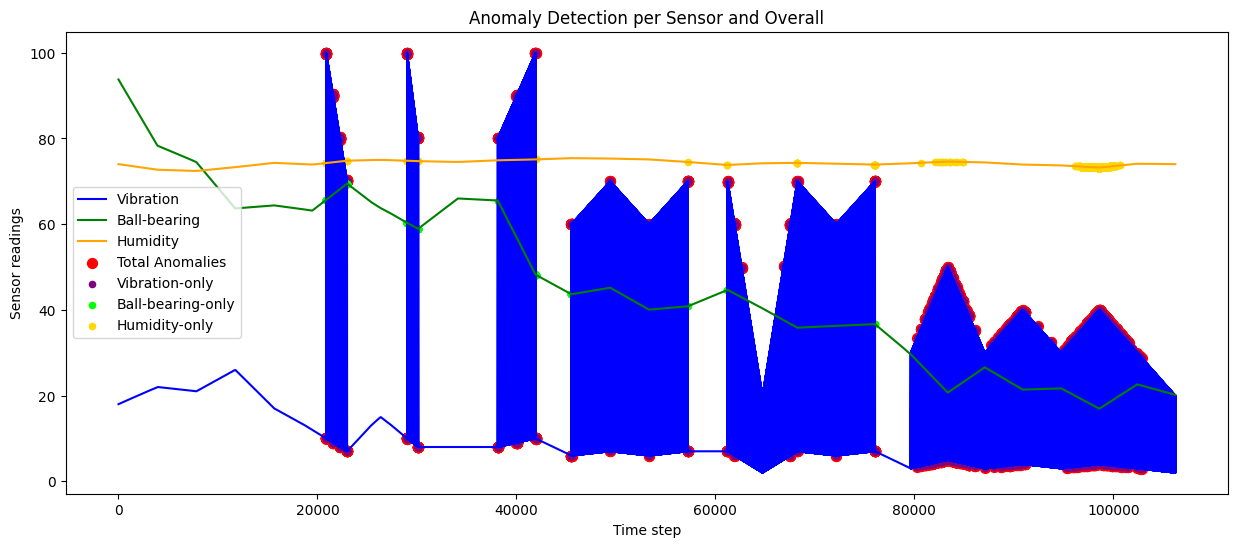

In [37]:
plt.figure(figsize=(15,6))
plt.plot(df['vibration'], label='Vibration', color='blue')
plt.plot(df['ball-bearing'], label='Ball-bearing', color='green')
plt.plot(df['humidity'], label='Humidity', color='orange')

plt.scatter(indices_total, df['vibration'].iloc[indices_total], color='red', label='Total Anomalies', s=50)
plt.scatter(indices_vib, df['vibration'].iloc[indices_vib], color='purple', label='Vibration-only', s=20)
plt.scatter(indices_bb, df['ball-bearing'].iloc[indices_bb], color='lime', label='Ball-bearing-only', s=20)
plt.scatter(indices_hum, df['humidity'].iloc[indices_hum], color='gold', label='Humidity-only', s=20)

plt.xlabel("Time step")
plt.ylabel("Sensor readings")
plt.title("Anomaly Detection per Sensor and Overall")
plt.legend()
plt.show()


In [28]:
normal_mse = mse[mse <= threshold]
anomaly_mse = mse[mse > threshold]

print(f"Mean MSE normal windows: {normal_mse.mean():.5f}")
print(f"Mean MSE anomalous windows: {anomaly_mse.mean():.5f}")


Mean MSE normal windows: 0.00062
Mean MSE anomalous windows: 0.01562


In [29]:
for i in anomaly_indices[:5]:  # first 5 anomalies
    print(df.iloc[i])


ball-bearing    65.636
humidity        74.254
vibration       10.031
Name: 20857, dtype: float64
ball-bearing    65.640
humidity        74.254
vibration       10.029
Name: 20858, dtype: float64
ball-bearing    65.641
humidity        74.254
vibration       10.027
Name: 20859, dtype: float64
ball-bearing    65.643
humidity        74.255
vibration       10.026
Name: 20860, dtype: float64
ball-bearing    65.644
humidity        74.255
vibration       10.025
Name: 20861, dtype: float64


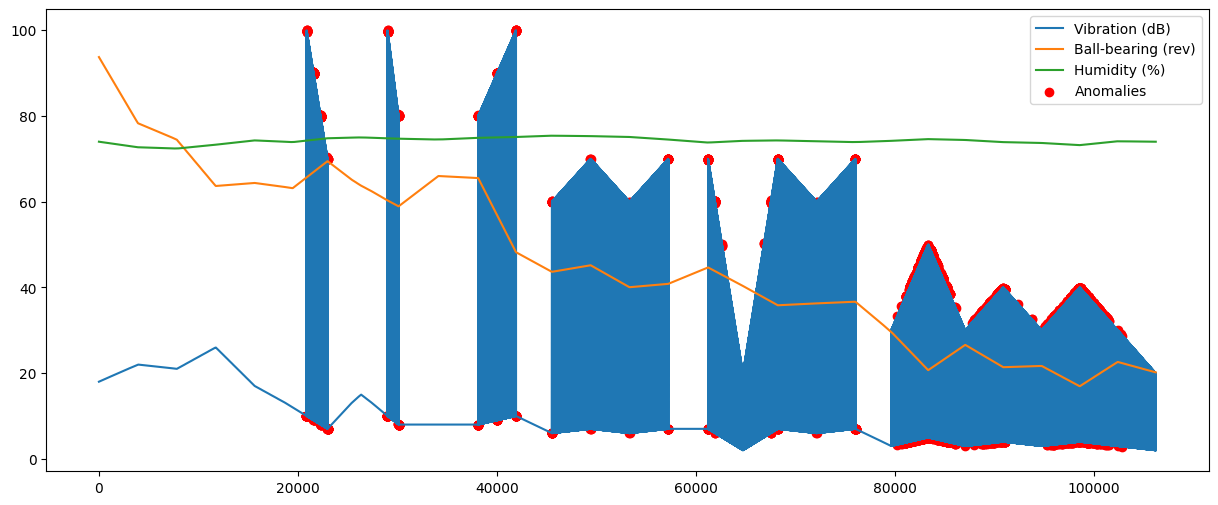

In [30]:
plt.figure(figsize=(15,6))
plt.plot(df['vibration'], label='Vibration (dB)')
plt.plot(df['ball-bearing'], label='Ball-bearing (rev)')
plt.plot(df['humidity'], label='Humidity (%)')
plt.scatter(anomaly_indices, df['vibration'].iloc[anomaly_indices], color='red', label='Anomalies')
plt.legend()
plt.show()
